 # GROUP 5 - FINAL PROJECT
 
  
 <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

<!-- Bank Money Theme -->
<div style="border-radius: 0px; border: 2px solid #3eb489; padding: 15px; background-color: #ddefdd; font-size: 120%; text-align: center; color: #007d3c; font-weight: bold;">
   Table of Contents
</div>

* [0. 🛠️ Utility Functions](#0.-Utility-Functions) 

* [1. 💾 Import Libraries](#1.-Import-Libraries) 

* [2. 📑 Read and Explain Dataset](#2.-Read-and-Explain-Dataset)

* [3. 📊 Exploratory Data Analysis](#3.-Exploratory-Data-Analysis) 

* [4. 🛠️ Data Preprocessing](#4.-Data-Preprocessing)

* [5. 🌴 ML Classification Models](#5.-ML-Classification-Models)

* [6. ⚙️ Data Resampling](#6.-Data-Resampling)

* [7. ⚙️ Hyperparameter Tuning](#7.-Hyperparameter-Tuning)

* [8. 🚀 Training Final Model](#8.-Training-Final-Model)

* [9. 🖩 Calculate Loss](#9.-Calculate-Loss)

* [10. 🖩 Calculate Confidence Interval](#10.-Calculate-Confidence-Interval)





## <div style="border-radius:0px; border:#3eb489 solid; padding: 15px; background-color: #ddefdd; font-size:100%; text-align:center">0. Utility Functions</div>


In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    confusion_matrix,
    roc_curve, 
    roc_auc_score, 
)

def plot_series(
    series: pd.Series, 
    title: str="Bar Chart", 
    xlabel: str="Index", 
    ylabel: 
    str="Values"
    ) -> None:
    """
    Generates a bar chart from a pandas Series using Plotly Express.

    Args:
        series (pandas.Series): The Series containing data for the bar chart.
        title (str, optional): Title of the chart. Defaults to "Bar Chart".
        xlabel (str, optional): Label for the x-axis. Defaults to "Index".
        ylabel (str, optional): Label for the y-axis. Defaults to "Values".
    """
    # Convert the series to a DataFrame
    df = series.reset_index()
    df.columns = ['index', 'value']

    # Create the bar chart
    fig = px.bar(df, x='index', y='value', title=title, labels={'index': xlabel, 'value': ylabel})
    
    # Customize the layout
    fig.update_layout(xaxis_tickangle=-45)  # Rotate x-axis labels for readability

    # Show the plot
    fig.show()
    

def corr_numeric_only(
    df: pd.DataFrame, 
    width: int = 800, 
    height: 
    int = 600
    ) -> pd.DataFrame:
    """
    Calculates and visualizes the correlation matrix for numeric columns in a DataFrame.

    Args:
        df (pandas.Dataframe): The input DataFrame.
        width (int, optional): The width of the plot. Default is 800.
        height (int, optional): The height of the plot. Default is 600.

    Returns:
        pd.DataFrame: A DataFrame containing the correlation matrix for numeric columns.
    """
    # Select only columns with numeric data types
    numeric_df = df.select_dtypes(include=[np.number])

    # Calculate the correlation matrix
    corr_matrix = numeric_df.corr()

    # Round the correlation matrix to two decimals
    corr_matrix = corr_matrix.round(2)

    # Create a heatmap using plotly.express
    fig = px.imshow(corr_matrix,
                    text_auto=True,
                    labels=dict(color="Correlation"),
                    x=corr_matrix.columns,
                    y=corr_matrix.columns,
                    title="Correlation Matrix")

    # Update the layout to set the figure size
    fig.update_layout(width=width, height=height)

    # Show the plot
    fig.show()

    return corr_matrix


def train_classifier_and_plot_roc(
    clf: BaseEstimator, 
    X_train: pd.DataFrame,
    y_train: pd.Series, 
    X_test: pd.DataFrame, 
    y_test: pd.Series,
    threshold: float = 0.5
) -> tuple[float, float, float, float, float]:
    """
    Trains a classifier, plots ROC curve, and calculates the AUROC with a specified threshold.
    
    Args:
        clf (BaseEstimator): The classifier to train.
        X_train (pd.DataFrame): Training feature data.
        y_train (pd.Series): Training labels.
        X_test (pd.DataFrame): Test feature data.
        y_test (pd.Series): Test labels.
        threshold (float, optional): The threshold for classifying an instance as 1 or 0.

    Returns:
        tuple[float, float, float, float, float]: A tuple containing accuracy, precision, recall, specificity, and AUROC.
    """

    clf.fit(X_train, y_train)

    # Get predicted probabilities
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    
    # Apply the custom threshold to get predicted classes
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Calculate confusion matrix to get TN and FP for specificity
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Calculate ROC curve and AUROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auroc = roc_auc_score(y_test, y_pred_proba)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUROC: {auroc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Dummy Classifier")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.title(f"ROC Curve - {clf.__class__.__name__}")
    plt.show()

    return accuracy, precision, recall, specificity, auroc


def calculate_loss(df: pd.DataFrame, model: str) -> float:
    """
    Calculate the total loss for a specific model's predictions.
    
    Args:
        df (pd.DataFrame): DataFrame containing the 'dollar_loss_dtc' and 'dollar_loss_rfc' columns.
        model (str): Identifier for the desired model, 'dtc' for DecisionTreeClassifier, and 'rfc' for RandomForestClassifier.
    
    Returns:
        float: The sum of the specific model's dollar losses.

    Raises:
        ValueError: If an invalid model identifier is provided.
    """
    if model == 'dtc':
        return df['expected_loss_dtc'].sum()
    elif model == 'rfc':
        return df['expected_loss_rfc'].sum()
    else:
        raise ValueError('Invalid model identifier.')

def bootstrap(df: pd.DataFrame, model: BaseEstimator, n_samples: int=1000, ci: int=95) -> tuple[float, float]:
    """Calculate the confidence interval of the loss function using the bootstrap method.

    Args:
        df (pd.DataFrame): Dataframe containing the samples. 
        model (BaseEstimator): Model to use.
        n_samples (int, optional): Number of samples in the bootstrap. Defaults to 1000.
        ci (int, optional): Confidence interval range. Defaults to 95.

    Returns:
        tuple[float, float]: The lower and upper bound.
    """
    np.random.seed(42)  # For reproducibility
    losses = np.zeros(n_samples)
    for i in range(n_samples):
        sampled_df = df.sample(frac=1, replace=True)
        losses[i] = calculate_loss(sampled_df, model)

    lower_percentile = (100 - ci) / 2
    upper_percentile = 100 - lower_percentile
    lower_bound = np.percentile(losses, lower_percentile)
    upper_bound = np.percentile(losses, upper_percentile)

    return lower_bound, upper_bound

## <div style="border-radius:0px; border:#3eb489 solid; padding: 15px; background-color: #ddefdd; font-size:100%; text-align:center">1. Import Libraries</div>

In [2]:
# data
import pandas as pd
import numpy as np


# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

## <div style="border-radius:0px; border:#3eb489 solid; padding: 15px; background-color: #ddefdd; font-size:100%; text-align:center">2. Read and Explain Dataset</div>

In [3]:
data = pd.read_csv("./credit_risk_dataset.csv") 

# Print sample
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


<div style="background-color: #ddefdd; padding: 10px; border-radius: 10px; color: #007d3c; text-align: center; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);">
    <h1 style="font-size: 24px;">Feature Descriptions</h1>
</div>

<div style="background-color: #f3faf3; padding: 15px; border-radius: 10px; margin-top: 20px; text-align: left;">
    <ul>
        <li><b>person_age:</b> Age of the individual applying for the loan.</li>
        <li><b>person_income:</b> Annual income of the individual.</li>
        <li><b>person_home_ownership:</b> Type of home ownership of the individual.
            <ul>
                <li>rent: The individual is currently renting a property.</li>
                <li>mortgage: The individual has a mortgage on the property they own.</li>
                <li>own: The individual owns their home outright.</li>
                <li>other: Other categories of home ownership that may be specific to the dataset.</li>
            </ul>
        </li>
        <li><b>person_emp_length:</b> Employment length of the individual in years.</li>
        <li><b>loan_intent:</b> The intent behind the loan application.</li>
        <li><b>loan_grade:</b> The grade assigned to the loan based on the creditworthiness of the borrower.
            <ul>
                <li>A: The borrower has a high creditworthiness, indicating low risk.</li>
                <li>B: The borrower is relatively low-risk, but not as creditworthy as Grade A.</li>
                <li>C: The borrower's creditworthiness is moderate.</li>
                <li>D: The borrower is considered to have higher risk compared to previous grades.</li>
                <li>E: The borrower's creditworthiness is lower, indicating a higher risk.</li>
                <li>F: The borrower poses a significant credit risk.</li>
                <li>G: The borrower's creditworthiness is the lowest, signifying the highest risk.</li>
            </ul>
        </li>
        <li><b>loan_amnt:</b> The loan amount requested by the individual.</li>
        <li><b>loan_int_rate:</b> The interest rate associated with the loan.</li>
        <li><b>loan_percent_income:</b> The percentage of income represented by the loan amount.</li>
        <li><b>cb_person_default_on_file:</b> Historical default of the individual as per credit bureau records.
            <ul>
                <li>Y: The individual has a history of defaults on their credit file.</li>
                <li>N: The individual does not have any history of defaults.</li>
            </ul>
        </li>
        <li><b>cb_preson_cred_hist_length:</b> The length of credit history for the individual.</li>
        <b>Target variable:</b>
        <li><b>loan_status:</b> Loan status, where 0 indicates non-default and 1 indicates default.
            <ul>
                <li>0: Non-default - The borrower successfully repaid the loan as agreed, and there was no default.</li>
                <li>1: Default - The borrower failed to repay the loan according to the agreed-upon terms and defaulted on the loan.</li>
            </ul>
        </li>
    </ul>
</div>


## <div style="border-radius:0px; border:#3eb489 solid; padding: 15px; background-color: #ddefdd; font-size:100%; text-align:center">3. Exploratory Data Analysis</div>

In [4]:
data.shape

(32581, 12)

**Observation:** The dataset consists of 12 columns and 32581 samples.

In [5]:
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [6]:
data.tail()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26
32580,66,42000,RENT,2.0,MEDICAL,B,6475,9.99,0,0.15,N,30


In [7]:
data.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [9]:
plot_series(data.isnull().sum(), title="Null values per column", xlabel="Column", ylabel="Counts")

In [10]:
plot_series(data.nunique(), title="Unique values per column", xlabel="Column", ylabel="Counts")

In [11]:
plot_series(data.loan_status.value_counts(), title="Loan status", xlabel="Loan status", ylabel="Counts")

**Observation:** More people are able to pay back there loans (0) compared to those that are not (1).

In [12]:
print(f"The number of duplicated rows is: {data.duplicated().sum()}")

The number of duplicated rows is: 165


In [13]:
corr_numeric_only(data)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
person_age,1.00,0.17,0.16,0.05,0.01,-0.02,-0.04,0.86
person_income,0.17,1.00,0.13,0.27,0.00,-0.14,-0.25,0.12
person_emp_length,0.16,0.13,1.00,0.11,-0.06,-0.08,-0.05,0.14
loan_amnt,0.05,0.27,0.11,1.00,0.15,0.11,0.57,0.04
loan_int_rate,0.01,0.00,-0.06,0.15,1.00,0.34,0.12,0.02
loan_status,-0.02,-0.14,-0.08,0.11,0.34,1.00,0.38,-0.02
loan_percent_income,-0.04,-0.25,-0.05,0.57,0.12,0.38,1.00,-0.03
cb_person_cred_hist_length,0.86,0.12,0.14,0.04,0.02,-0.02,-0.03,1.00


In [14]:
# Plot histogram with 20 bins using plotly.express
fig = px.histogram(data, x='person_age', nbins=20, title='Distribution of Ages')

# Update layout for titles and labels
fig.update_layout(
    xaxis_title='Age',
    yaxis_title='Frequency',
    width=1000,
    height=600
)
fig.update_traces(marker=dict(line=dict(color='black', width=1)))

# Show plot
fig.show()

**Observation**: Most of the people in the dataset are younger (20-40).

### Filter away outliers in age

In [15]:
# Filter data to include only people under the age of 80
filtered_data = data[data['person_age'] < 80]

# Plot histogram with 20 bins using plotly.express
fig = px.histogram(filtered_data, x='person_age', nbins=20, title='Distribution of Ages')

# Update layout for titles and labels
fig.update_layout(
    xaxis_title='Age',
    yaxis_title='Frequency',
    width=1000,
    height=600
)
fig.update_traces(marker=dict(line=dict(color='black', width=1)))

# Show plot
fig.show()

### Employment Length

In [16]:
# Plot histogram with 20 bins using plotly.express
fig = px.histogram(data, x='person_emp_length', nbins=20, title='Distribution of Employment Length')

# Update layout for titles and labels
fig.update_layout(
    xaxis_title='Age',
    yaxis_title='Frequency',
    width=1000,
    height=600
)
fig.update_traces(marker=dict(line=dict(color='black', width=1)))

# Show plot
fig.show()

**Filter away outlier employment lengths**

In [ ]:
filtered_data = data[data['person_emp_length'] < 60]

# Plot histogram with 20 bins using plotly.express
fig = px.histogram(filtered_data, x='person_emp_length', nbins=20, title='Distribution of Employment Length')

# Update layout for titles and labels
fig.update_layout(
    xaxis_title='Age',
    yaxis_title='Frequency',
    width=1000,
    height=600
)
fig.update_traces(marker=dict(line=dict(color='black', width=1)))

# Show plot
fig.show()

## Loan Amount

In [ ]:
# Plot histogram with 20 bins using plotly.express
fig = px.histogram(data, x='loan_amnt', nbins=10, title='Loan Amount')

# Update layout for titles and labels
fig.update_layout(
    xaxis_title='Loan Amount ($)',
    yaxis_title='Frequency',
    width=1000,
    height=600
)
fig.update_traces(marker=dict(line=dict(color='black', width=1)))

# Show plot
fig.show()

**Observation:** Most loans are between 0 and $15k

In [19]:
level_counts=data.person_home_ownership.value_counts()
fig=px.pie(values=level_counts.values,
          names=level_counts.index,
          color_discrete_sequence=px.colors.sequential.Mint,
          title= 'Home Ownership'
          )
fig.update_traces(textinfo='label+percent+value', textfont_size=13,
                  marker=dict(line=dict(color='#102000', width=0.2)))

fig.data[0].marker.line.width = 2
fig.data[0].marker.line.color='gray'
fig.show()

In [20]:
level_counts=data.loan_grade.value_counts()
fig=px.pie(values=level_counts.values,
          names=level_counts.index,
          color_discrete_sequence=px.colors.sequential.Mint,
          title= 'Loan Grade'
          )
fig.update_traces(textinfo='label+percent+value', textfont_size=13,
                  marker=dict(line=dict(color='#102000', width=0.2)))

fig.data[0].marker.line.width = 2
fig.data[0].marker.line.color='gray'
fig.show()

**Observation:** Loan Grades A and B comprise 65.2% of the total.

In [21]:
grade_default = pd.crosstab(data['loan_grade'], data['loan_status'])
grade_default.reset_index(inplace=True)
grade_default_melted = grade_default.melt(id_vars=['loan_grade'])

fig = px.histogram(
    grade_default_melted, 
    x="loan_grade", 
    y="value", 
    color="loan_status", 
    title="Grade Defaults by Loan Status", 
    barmode='group',
    labels={"loan_grade": "Loan Grade", "value": "Count"})
fig.show()

In [22]:
level_counts=data.loan_intent.value_counts()
fig=px.pie(values=level_counts.values,
          names=level_counts.index,
          color_discrete_sequence=px.colors.sequential.Mint,
          title= 'Loan Intent'
          )
fig.update_traces(textinfo='label+percent+value', textfont_size=10,
                  marker=dict(line=dict(color='#102000', width=0.1)))

fig.data[0].marker.line.width = 2
fig.data[0].marker.line.color='gray'
fig.show()

**Observation:** Loan Intent is almost equally distributed

In [23]:
fig=px.histogram(data, nbins=10,x = 'cb_person_cred_hist_length', text_auto = '.2f',template = 'presentation', title = 'person credit history length',color_discrete_sequence=px.colors.sequential.Mint)
fig.update_layout()
fig.show()

**Observation:** Most people have a credit history between 0-10 years.

## <div style="border-radius:0px; border:#3eb489 solid; padding: 15px; background-color: #ddefdd; font-size:100%; text-align:center">4. Data Preprocessing</div>

**Split the dataset into train (80%) and test (20%) sets.**

In [24]:
X = data.drop(['loan_status'], axis=1)
y = data['loan_status']

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=0)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

print(X_train.shape,X_test.shape)

(26064, 11) (6517, 11)


**One-hot encode nominal data**

In [26]:
from sklearn.preprocessing import OneHotEncoder
ohe_columns = ['cb_person_default_on_file','loan_grade', 'person_home_ownership', 'loan_intent']
ohe = OneHotEncoder()
ohe.fit(X_train[ohe_columns])

merge_ohe_col = np.concatenate((ohe.categories_[0], 
                ohe.categories_[1],
                ohe.categories_[2],
                ohe.categories_[3],))
ohe_data_train = pd.DataFrame(ohe.transform(X_train[ohe_columns]).toarray(), columns=merge_ohe_col)

ohe_data_test = pd.DataFrame(ohe.transform(X_test[ohe_columns]).toarray(),columns=merge_ohe_col)
print(X_train.shape)

X_train = pd.concat([ohe_data_train, X_train], axis=1).drop(ohe_columns, axis=1)
X_test = pd.concat([ohe_data_test, X_test], axis=1).drop(ohe_columns, axis=1)


(26064, 11)


In [27]:
# Keep a copy of original values as we will scale and modify the values. 
X_train_original = X_train.copy()
X_test_original = X_test.copy()

**Use iterative imputing to impute the null values in the dataset**

In [28]:
plot_series(X_train.isnull().sum(), title="Null values in train set", xlabel="Column", ylabel="Counts")

In [29]:
plot_series(X_test.isnull().sum(), title="Null values in test set", xlabel="Column", ylabel="Counts")

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

impute_mean = IterativeImputer(estimator=RandomForestRegressor(), random_state=0)
impute_mean.fit(X_train)
X_train = pd.DataFrame(impute_mean.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(impute_mean.transform(X_test), columns=X_test.columns)

In [31]:
X_train.isnull().sum()

N                             0
Y                             0
A                             0
B                             0
C                             0
D                             0
E                             0
F                             0
G                             0
MORTGAGE                      0
OTHER                         0
OWN                           0
RENT                          0
DEBTCONSOLIDATION             0
EDUCATION                     0
HOMEIMPROVEMENT               0
MEDICAL                       0
PERSONAL                      0
VENTURE                       0
person_age                    0
person_income                 0
person_emp_length             0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_cred_hist_length    0
dtype: int64

In [32]:
X_test.isnull().sum()

N                             0
Y                             0
A                             0
B                             0
C                             0
D                             0
E                             0
F                             0
G                             0
MORTGAGE                      0
OTHER                         0
OWN                           0
RENT                          0
DEBTCONSOLIDATION             0
EDUCATION                     0
HOMEIMPROVEMENT               0
MEDICAL                       0
PERSONAL                      0
VENTURE                       0
person_age                    0
person_income                 0
person_emp_length             0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_cred_hist_length    0
dtype: int64

## Scale the columns

In [33]:
from sklearn.preprocessing import StandardScaler

scale_cols = [
    'person_income',
    'person_age',
    'person_emp_length', 
    'loan_amnt',
    'loan_int_rate',
    'cb_person_cred_hist_length',
    'loan_percent_income', 
]


scaler_normal = StandardScaler()

X_train.loc[:,scale_cols] = scaler_normal.fit_transform(X_train.loc[:,scale_cols])
X_test.loc[:,scale_cols] = scaler_normal.transform(X_test.loc[:,scale_cols])

## <div style="border-radius:0px; border:#3eb489 solid; padding: 15px; background-color: #ddefdd; font-size:100%; text-align:center">5. ML Classification Models</div>

**Accoring to Velka (2020) decision tree and random forest classifiers seem to perform the best. [Link to paper](https://kth.diva-portal.org/smash/record.jsf?pid=diva2%3A1464145&dswid=-6392)**

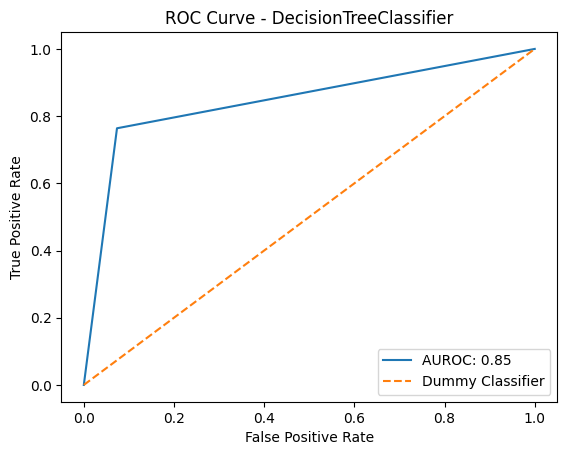

For  dtc
Accuracy -  0.8930489489028695
Precision -  0.7284390591589451
Recall -  0.7638266068759342
Specificity -  0.926433674454528
AUROC - 0.8451301406652311



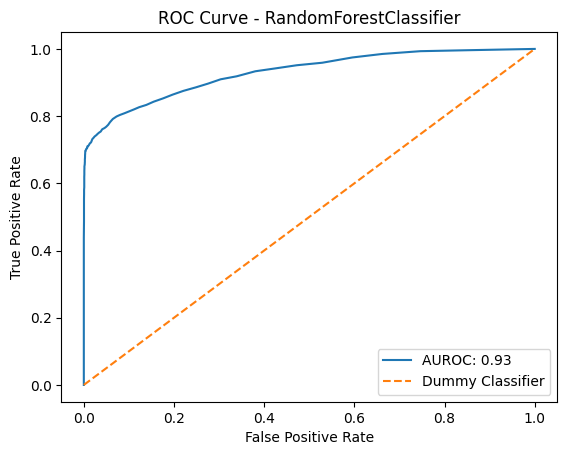

For  rfc
Accuracy -  0.9283412613165567
Precision -  0.8962693357597816
Recall -  0.7361733931240658
Specificity -  0.9779880285769453
AUROC - 0.929487212789606



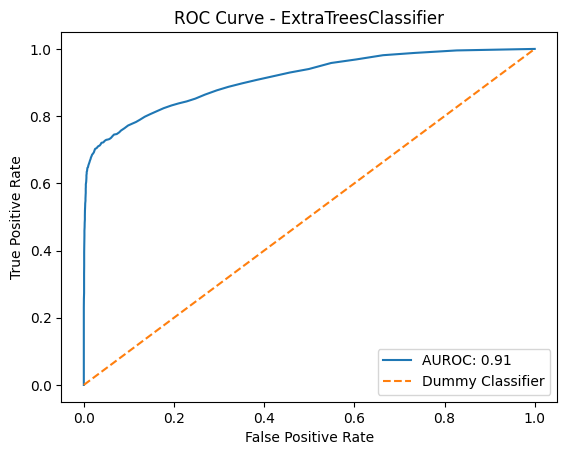

For  etc
Accuracy -  0.9048642013196256
Precision -  0.7909238249594813
Recall -  0.7294469357249627
Specificity -  0.9501834330951922
AUROC - 0.9114794973722499



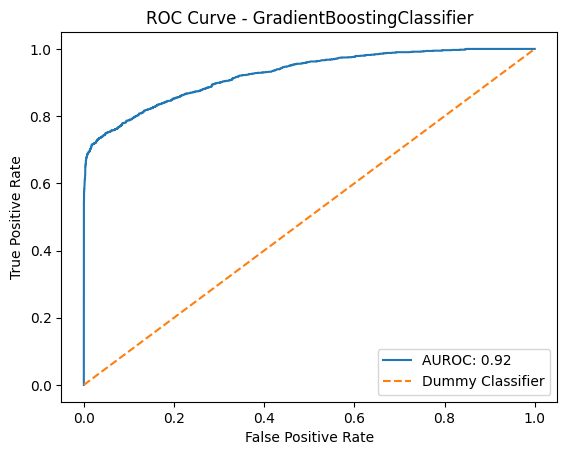

For  gbc
Accuracy -  0.9172932330827067
Precision -  0.8417450812660393
Recall -  0.7354260089686099
Specificity -  0.964278818304692
AUROC - 0.9245503500828776



In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier(class_weight='balanced')
etc = ExtraTreesClassifier()
gbc = GradientBoostingClassifier()

clf = {
    'dtc': dtc,
    'rfc': rfc,
    'etc': etc,
    'gbc': gbc
}

X_train = X_train.drop(columns=[col for col in X_train.columns if pd.isna(col)], axis=1)
X_test = X_test.drop(columns=[col for col in X_test.columns if pd.isna(col)],  axis=1)

accuracy_scores = []
precision_scores = []
recall_scores = []
specificity_scores = []

for name, model in clf.items():
    current_accuracy,current_precision, current_recall, current_specificity, current_auroc = train_classifier_and_plot_roc(model, X_train, y_train, X_test, y_test, threshold=0.35)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    print("Recall - ",current_recall)
    print("Specificity - ",current_specificity)
    print("AUROC -",current_auroc)
    print()
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)
    recall_scores.append(current_recall)
    specificity_scores.append(current_specificity)

**Observation:** The DecisionTreeClassifier performed worst on AUROC, but had the most balance between precision and recall. The other models heavily favored precision and had very low recall. The model that performed best on the AUROC metrics was the RandomForestClassifier. I will try to tune both of these models.

In loan default prediction, consider:

1- **Recall** (Sensitivity): Measures correct default identification, minimizing financial setbacks due to undetected defaults.

2- **Specificity**: Assesses accurate non-default detection, preventing loan denials for creditworthy applicants.

3- **Precision**: Determines positive prediction accuracy, avoiding false defaults and protecting lender-borrower relationships.

## <div style="border-radius:0px; border:#3eb489 solid; padding: 15px; background-color: #ddefdd; font-size:100%; text-align:center">6. Data Resampling</div>

In [35]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=0)

X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

## <div style="border-radius:0px; border:#3eb489 solid; padding: 15px; background-color: #ddefdd; font-size:100%; text-align:center">7. Hyperparameter Tuning</div>

## Tune DecisionTreeClassifier

Classificaiton report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      5179
           1       0.71      0.75      0.73      1338

    accuracy                           0.89      6517
   macro avg       0.82      0.84      0.83      6517
weighted avg       0.89      0.89      0.89      6517

Confusion Matrix: 


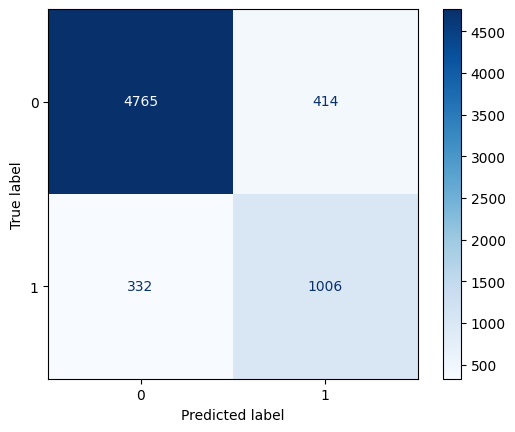

Best Parameters: {'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 50, 'criterion': 'entropy'}


In [36]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Define the parameter grid
param_dist = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize the classifier
clf = DecisionTreeClassifier(random_state=0)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=100, scoring='f1', cv=5, random_state=0, n_jobs=-1)

# Fit the model
random_search.fit(X_train_res, y_train_res)

# Get the best estimator
best_clf = random_search.best_estimator_

# Predict on the test set
y_pred = best_clf.predict(X_test)

# Print classification report
print("Classificaiton report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix: ")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

dtc_best_params = random_search.best_params_

# Print the best parameters
print("Best Parameters:", random_search.best_params_)

## Tune RandomForestClassifier

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      5179
           1       0.92      0.72      0.81      1338

    accuracy                           0.93      6517
   macro avg       0.93      0.85      0.88      6517
weighted avg       0.93      0.93      0.93      6517

Confusion Matrix:


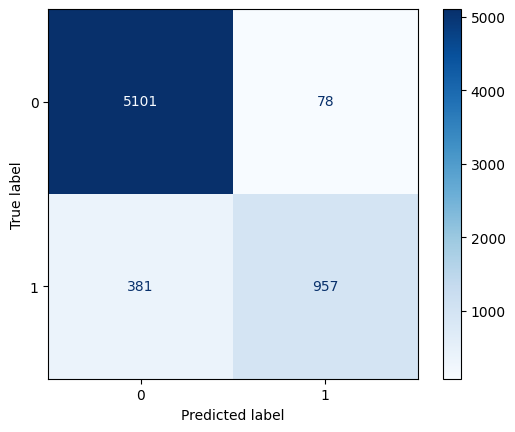

Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'criterion': 'entropy', 'bootstrap': False}


In [37]:
# Define the parameter grid for RandomForestClassifier
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize the RandomForestClassifier
clf = RandomForestClassifier(random_state=0)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=100, scoring='f1', cv=5, random_state=0, n_jobs=-1)

# Fit the model
random_search.fit(X_train_res, y_train_res)

# Get the best estimator
best_clf = random_search.best_estimator_

# Predict on the test set
y_pred = best_clf.predict(X_test)

# Print classification report
print("Classification report:")
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

rfc_best_params = random_search.best_params_

# Print the best parameters
print("Best Parameters:", rfc_best_params)

## <div style="border-radius:0px; border:#3eb489 solid; padding: 15px; background-color: #ddefdd; font-size:100%; text-align:center">8. Train Final Model</div>

**Use the best parameters found in step 7. to train the final models**

### Train Final DecisionTreeClassifier

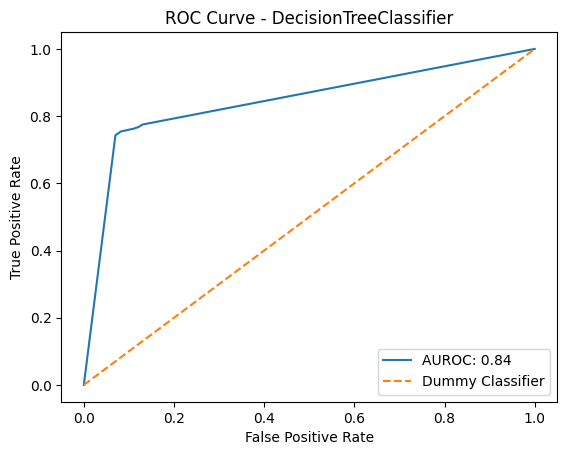

For  RandomForestClassifier
Accuracy -  0.8625134264232008
Precision -  0.638125
Recall -  0.7630792227204783
Specificity -  0.8882023556671172
AUROC - 0.8436412169301631



In [38]:
# Use parameters from hyperparameter tuning
dtc = DecisionTreeClassifier(
    criterion=dtc_best_params['criterion'],
    max_depth=dtc_best_params['max_depth'],
    min_samples_split=dtc_best_params['min_samples_split'],
    min_samples_leaf=dtc_best_params['min_samples_leaf'],
    max_features=dtc_best_params['max_features'],
    )


current_accuracy,current_precision, current_recall, current_specificity, current_auroc = train_classifier_and_plot_roc(dtc, X_train_res, y_train_res, X_test, y_test, 0.35)

print("For ",clf.__class__.__name__)
print("Accuracy - ",current_accuracy)
print("Precision - ",current_precision)
print("Recall - ",current_recall)
print("Specificity - ",current_specificity)
print("AUROC -",current_auroc)
print()

### Train Final RandomForestClassifier

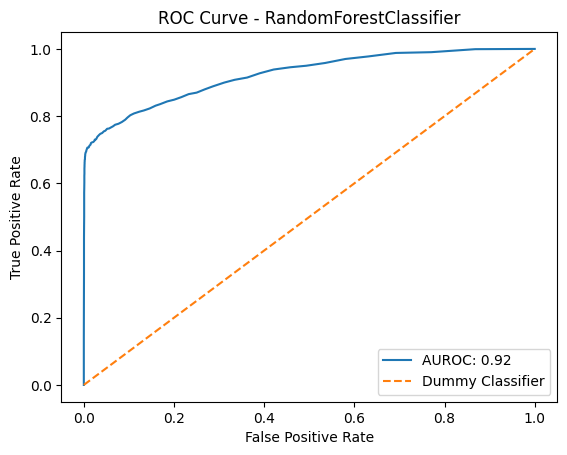

For  RandomForestClassifier
Accuracy -  0.907012429031763
Precision -  0.7793893129770992
Recall -  0.7630792227204783
Specificity -  0.9441977215678703
AUROC - 0.9232721196992223



In [39]:
# Use parameters from hyperparameter tuning
rfc = RandomForestClassifier(
    random_state=0,
    criterion=rfc_best_params['criterion'],
    max_depth=rfc_best_params['max_depth'],
    min_samples_split=rfc_best_params['min_samples_split'],
    min_samples_leaf=rfc_best_params['min_samples_leaf'],
    max_features=rfc_best_params['max_features'],
    bootstrap=rfc_best_params['bootstrap']
    )

current_accuracy,current_precision, current_recall, current_specificity, current_auroc = train_classifier_and_plot_roc(rfc, X_train_res, y_train_res, X_test, y_test, 0.35)

print("For ",clf.__class__.__name__)
print("Accuracy - ",current_accuracy)
print("Precision - ",current_precision)
print("Recall - ",current_recall)
print("Specificity - ",current_specificity)
print("AUROC -",current_auroc)
print()

## <div style="border-radius:0px; border:#3eb489 solid; padding: 15px; background-color: #ddefdd; font-size:100%; text-align:center">9. Calculate Loss</div>

**Expected Loss** will be calculated with a LGD of 1, assumes that the entire loan will default. The loss is predicted loss can therefore be calculated as:
$\text{Loss} = \text{Loan amount} \cdot \text{Probability of Default} \cdot \text{LGD} $

In [40]:
predict_loss_df = pd.DataFrame(X_test_original['loan_amnt'])

# Column 1 is probability of default
predict_loss_df['loss_prob_dtc'] = dtc.predict_proba(X_test)[:, 1]
predict_loss_df['loss_prob_rfc'] = rfc.predict_proba(X_test)[:, 1]

# Calculate Expected Loss
predict_loss_df['expected_loss_dtc'] = predict_loss_df['loan_amnt'] * predict_loss_df['loss_prob_dtc'] * 1
predict_loss_df['expected_loss_rfc'] = predict_loss_df['loan_amnt'] * predict_loss_df['loss_prob_rfc'] * 1
predict_loss_df.head()

,loan_amnt,loss_prob_dtc,loss_prob_rfc,expected_loss_dtc,expected_loss_rfc
0,2400,0.0,0.33,0.0,792.0
1,25000,0.0,0.00,0.0,0.0
2,6000,0.0,0.06,0.0,360.0
3,15000,0.0,0.13,0.0,1950.0
4,10000,0.0,0.00,0.0,0.0


In [41]:
print(f"Value of portfolio (test set): ${predict_loss_df['loan_amnt'].sum():,}")
print(f"Predicted loss by DTC: ${predict_loss_df['expected_loss_dtc'].sum():,.2f} ({(predict_loss_df['expected_loss_dtc'].sum() / predict_loss_df['loan_amnt'].sum()*100):.2f}%)")      
print(f"Predicted loss by RFC: ${predict_loss_df['expected_loss_rfc'].sum():,.2f} ({(predict_loss_df['expected_loss_rfc'].sum() / predict_loss_df['loan_amnt'].sum()*100):.2f}%)")      

Value of portfolio (test set): $62,313,900
Predicted loss by DTC: $15,899,860.42 (25.52%)
Predicted loss by RFC: $15,910,476.25 (25.53%)


## <div style="border-radius:0px; border:#3eb489 solid; padding: 15px; background-color: #ddefdd; font-size:100%; text-align:center">10. Calculate Confidence Interval</div>

In [42]:
# Assuming 'predict_loss_df' is the DataFrame that contains 'loan_amnt', 'dollar_loss_dtc', and 'dollar_loss_rfc'
lower_bound_dtc, upper_bound_dtc = bootstrap(predict_loss_df, 'dtc')
lower_bound_rfc, upper_bound_rfc = bootstrap(predict_loss_df, 'rfc')

print(f"95% confidence interval for expected loss (Decision Tree): (${lower_bound_dtc:,.2f}, ${upper_bound_dtc:,.2f}) ({(lower_bound_dtc / predict_loss_df['loan_amnt'].sum())*100:.2f}%, {(upper_bound_dtc / predict_loss_df['loan_amnt'].sum())*100:.2f}%)")
print(f"95% confidence interval for expected loss (Random Forest): (${lower_bound_rfc:,.2f}, ${upper_bound_rfc:,.2f}) ({(lower_bound_rfc / predict_loss_df['loan_amnt'].sum())*100:.2f}%, {(upper_bound_rfc / predict_loss_df['loan_amnt'].sum())*100:.2f}%)")

95% confidence interval for expected loss (Decision Tree): ($15,009,479.69, $16,775,883.23) (24.09%, 26.92%)
95% confidence interval for expected loss (Random Forest): ($15,166,537.54, $16,629,728.47) (24.34%, 26.69%)
